# How to rediscover the Higgs boson yourself!

This notebook is to get a felling of how to do a real analysis. ATLAS Open Data http://opendata.atlas.cern has been used to rediscover the Higgs boson yourself!

The datasets used in this notebook have already been filtered to include at least 2 photons per event, so that processing is quicker.

This analysis loosely follows the discovery of the Higgs boson by ATLAS https://arxiv.org/pdf/1207.7214.pdf (mostly Section 5 and 5.1)

Feynman diagrams can be found at https://www.particlezoo.net

#### source, the main notebook can be found at  
https://github.com/meevans1/how-to-rediscover-the-higgs-with-photons/blob/master/Higgs%20photon%20analysis.ipynb

#### I edited it to be somehow simpiler and make sure the codes are compatible with the newer version of uproot (uproot4).


##### The Analysis is divided into 4 main steps:
Step1- PrepareData, as mentioned before, the data is already prepared.

Step2- PrepareSimulation, we don't have simulation used for that analysis.

Step3- Applying selection criteria on the higgs candidates.

step4- fitting the data and extracting the higgs mass.

edited by: Eslam Shokr
31/07/2023

In [213]:
import uproot  # for reading .root files
import pandas as pd  # to store data as dataframe
import numpy as np  # # for numerical calculations such as histogramming
import matplotlib.pyplot as plt  # for plotting
from lmfit.models import (
    PolynomialModel,
    GaussianModel,
)  # for the signal and background fits
from matplotlib.ticker import MaxNLocator, AutoMinorLocator  # for minor ticks

## Extract the tree from the root files using uproot

In [ ]:
# For using Data_A, Data_B, Data_C and Data_D you can use the following path:
# tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/" # web address

# get the tree from the root file using uproot
# data = uproot.open(
#     # "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_A.GamGam.root",
#     "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_B.GamGam.root",
#     # "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_C.GamGam.root",
#     # "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_D.GamGam.root",
# )["mini"]

#import uproot

#file_paths = [
#    "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_A.GamGam.root",
    #    "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_B.GamGam.root",
    #    "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_C.GamGam.root",
    #    "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_D.GamGam.root",
# ]

# create a list of trees #! if you want to use all the data, uncomment the upper part and comment this part
#data = [uproot.open(file_path)["mini"] for file_path in file_paths]
#concatenated_file = uproot.concatenate(data)

In [243]:
# get the tree from the root file using uproot, A is used for that test
# data = uproot.open("Input/GamGam/Data/data_A.GamGam.root")["mini"]
data = uproot.open(
    "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_A.GamGam.root"
)["mini"]

In [245]:
data.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
runNumber            | int32_t                  | AsDtype('>i4')
eventNumber          | int32_t                  | AsDtype('>i4')
channelNumber        | int32_t                  | AsDtype('>i4')
mcWeight             | float                    | AsDtype('>f4')
scaleFactor_PILEUP   | float                    | AsDtype('>f4')
scaleFactor_ELE      | float                    | AsDtype('>f4')
scaleFactor_MUON     | float                    | AsDtype('>f4')
scaleFactor_PHOTON   | float                    | AsDtype('>f4')
scaleFactor_TAU      | float                    | AsDtype('>f4')
scaleFactor_BTAG     | float                    | AsDtype('>f4')
scaleFactor_LepTR... | float                    | AsDtype('>f4')
scaleFactor_Photo... | float                    | AsDtype('>f4')
trigE                | bool                     | AsDtype(

## Filter the photon information and get the data in the form of DataFrame

pandas DataFrame gives us some flexibility in data manipulation.

In [201]:
# from the tree we can get the data as a pandas dataframe, you can also apply cut on filt==
dataFrame = data.arrays(
    filter_name="photon_*",
    library="pd",
)

In [202]:
dataFrame

,photon_n,photon_truthMatched,photon_trigMatched,photon_pt,photon_eta,photon_phi,photon_E,photon_isTightID,photon_ptcone30,photon_etcone20,photon_convType,photon_pt_syst
0,2,[],[True True],[46690.22265625 29442.607421875],[-1.7790892124176025 1.1680628061294556],[-2.1864736080169678 1.1273633241653442],[142247.59375 51918.0],[False False],[0.0 54738.84765625],[1209.197265625 575.0435791015625],[2 2],[0.0 0.0]
1,2,[],[True True],[60888.73828125 37795.01171875],[0.17411939799785614 -0.9689640998840332],[1.8595004081726074 -0.8882507681846619],[61814.0703125 56970.10546875],[False False],[5506.99169921875 11680.0419921875],[5396.2333984375 2005.253173828125],[1 0],[0.0 0.0]
2,2,[],[True True],[39186.2109375 25327.361328125],[0.13933658599853516 -1.309054970741272],[1.0165337324142456 -1.7878570556640625],[39567.22265625 50309.61328125],[False False],[3902.340576171875 16578.07421875],[3261.8388671875 21145.14453125],[2 0],[0.0 0.0]
3,2,[],[True True],[35529.6875 29579.59765625],[1.0483403205871582 1.2933013439178467],[1.587436556816101 -1.533585548400879],[56908.45703125 57963.6328125],[True True],[0.0 0.0],[-23.805450439453125 -614.49365234375],[0 0],[0.0 0.0]
4,2,[],[True True],[48605.8359375 29717.974609375],[-0.44870510697364807 0.35124853253364563],[0.7197853922843933 2.9040207862854004],[53581.54296875 31570.13671875],[False False],[8417.5751953125 0.0],[2472.8896484375 495.9525451660156],[0 0],[0.0 0.0]
...,...,...,...,...,...,...,...,...,...,...,...,...
430339,2,[],[True True],[40663.3125 37260.89453125],[0.6159602999687195 1.9347634315490723],[-2.739682674407959 0.16191378235816956],[48624.2890625 131658.84375],[True False],[0.0 0.0],[-226.6883544921875 1024.830078125],[0 1],[0.0 0.0]
430340,2,[],[True True],[93752.890625 38948.0859375],[0.7961970567703247 0.3877616822719574],[2.7667112350463867 -1.6571269035339355],[125072.65625 41913.05859375],[False True],[46238.4609375 3329.496337890625],[15101.859375 3755.927001953125],[3 0],[0.0 0.0]
430341,2,[],[True True],[39450.03515625 31067.44921875],[-0.659988284111023 -0.45694559812545776],[-0.19235870242118835 3.07224702835083],[48358.38671875 34367.7109375],[True False],[0.0 3168.038818359375],[2734.582763671875 5469.6484375],[4 4],[0.0 0.0]
430342,2,[],[True True],[65747.4921875 33625.58984375],[0.7092413306236267 0.4271511137485504],[0.35506388545036316 0.2253589779138565],[82988.65625 36740.1484375],[True False],[9194.203125 6461.23681640625],[2411.21533203125 988.6069946289062],[3 0],[0.0 0.0]


## Defining the cuts to obtain the higgs candidates

In [203]:
# cut on photon_pt
def cut_on_photon_pt(pt_list):
    return pt_list[0] > 30000 and pt_list[1] > 30000


# cut on photon_isTightID
def cut_on_tightID(tight_list):
    return tight_list[0] == 1 and tight_list[1] == 1


# cut on photon_etcone20
def cut_on_photon_etcone20(etcone20_list):
    return etcone20_list[0] < 3500 and etcone20_list[1] < 3500


# cut on photon_eta
def cut_on_photon_eta(eta_list):
    return (abs(eta_list[0]) > 1.52 or abs(eta_list[0]) < 1.37) and (
        abs(eta_list[1]) > 1.52 or abs(eta_list[1]) < 1.37
    )

# Apply cuts

In [204]:
# Apply the functions to create boolean masks for each condition
mask_photon_pt = dataFrame["photon_pt"].apply(cut_on_photon_pt)
mask_tightID = dataFrame["photon_isTightID"].apply(cut_on_tightID)
mask_photon_etcone20 = dataFrame["photon_etcone20"].apply(cut_on_photon_etcone20)
mask_photon_eta = dataFrame["photon_eta"].apply(cut_on_photon_eta)

# Combine the masks using logical AND (&)
combined_mask = mask_photon_pt & mask_tightID & mask_photon_etcone20 & mask_photon_eta

# Select only the rows where both conditions are True
selected_data = dataFrame[combined_mask]

In [205]:
selected_data

,photon_n,photon_truthMatched,photon_trigMatched,photon_pt,photon_eta,photon_phi,photon_E,photon_isTightID,photon_ptcone30,photon_etcone20,photon_convType,photon_pt_syst
10,2,[],[True True],[176121.15625 39629.14453125],[-0.8334919810295105 0.0947030708193779],[-0.29423871636390686 0.5672937631607056],[240922.3125 39806.98828125],[True True],[0.0 0.0],[272.1484375 -26.3897705078125],[2 0],[0.0 0.0]
11,2,[],[True True],[100427.6796875 95522.5703125],[1.7343542575836182 0.6880435943603516],[0.6559551954269409 -2.4571521282196045],[293338.34375 119039.1328125],[True True],[2238.390625 0.0],[8.248504638671875 -584.1983642578125],[0 0],[0.0 0.0]
55,2,[],[True True],[38297.3046875 32480.755859375],[0.05254824459552765 -0.8327684998512268],[-1.5148577690124512 1.7095263004302979],[38350.19140625 44409.64453125],[True True],[0.0 0.0],[1320.8095703125 -1617.200927734375],[4 2],[0.0 0.0]
76,2,[],[True True],[45906.0859375 34899.7421875],[0.560444176197052 -0.18553611636161804],[-2.951354503631592 -0.023520486429333687],[53306.27734375 35502.15625],[True True],[0.0 0.0],[-432.02734375 1166.5855712890625],[0 0],[0.0 0.0]
86,2,[],[True True],[78156.2265625 66979.34375],[0.22070465981960297 1.067368745803833],[-3.069084405899048 0.012800399214029312],[80067.484375 108896.046875],[True True],[15639.6201171875 8154.38134765625],[2606.63525390625 566.020263671875],[2 0],[0.0 0.0]
...,...,...,...,...,...,...,...,...,...,...,...,...
430264,2,[],[True True],[59073.9296875 49057.2734375],[2.0889763832092285 -0.5487157106399536],[-0.9638237357139587 2.294160842895508],[242216.625 56629.74609375],[True True],[0.0 0.0],[249.613037109375 -882.2891235351562],[0 2],[0.0 0.0]
430266,2,[],[True True],[62422.5 42199.74609375],[-1.720149040222168 -1.1424602270126343],[0.848680853843689 1.1039146184921265],[179914.140625 72868.484375],[True True],[0.0 1012.7913818359375],[1638.069091796875 -669.5621337890625],[0 0],[0.0 0.0]
430299,2,[],[True True],[41353.16796875 40531.18359375],[-0.24342593550682068 -0.6404326558113098],[2.4162867069244385 -0.49103081226348877],[42584.4453125 49131.2109375],[True True],[0.0 0.0],[1886.964599609375 -72.14031982421875],[0 0],[0.0 0.0]
430307,2,[],[True True],[57563.0546875 33026.76953125],[-0.6354982852935791 -0.6544519066810608],[2.412254571914673 -1.628854513168335],[69583.203125 40355.6484375],[True True],[0.0 4420.36279296875],[739.84375 1081.072265625],[2 0],[0.0 0.0]


## Define the invariant mass function

In [207]:
def calc_myy(photon_pt, photon_eta, photon_phi, photon_E):
    # x-component of photon[0] momentum
    px_0 = photon_pt[0] * np.cos(photon_phi[0])
    # y-component of photon[0] momentum
    py_0 = photon_pt[0] * np.sin(photon_phi[0])
    # z-component of photon[0] momentum
    pz_0 = photon_pt[0] * np.sinh(photon_eta[0])
    # x-component of photon[1] momentum
    px_1 = photon_pt[1] * np.cos(photon_phi[1])
    # y-component of photon[1] momentum
    py_1 = photon_pt[1] * np.sin(photon_phi[1])
    # z-component of photon[1] momentum
    pz_1 = photon_pt[1] * np.sinh(photon_eta[1])

    sumpx = px_0 + px_1  # x-component of diphoton momentum
    sumpy = py_0 + py_1  # y-component of diphoton momentum
    sumpz = pz_0 + pz_1  # z-component of diphoton momentum

    # magnitude of diphoton momentum
    sump = np.sqrt(sumpx**2 + sumpy**2 + sumpz**2)

    # energy of diphoton system
    sumE = photon_E[0] + photon_E[1]

    return np.sqrt(sumE**2 - sump**2) / 1000  # /1000 to go from MeV to GeV

## # Calculate reconstructed diphoton invariant mass using the function calc_myy defined above


In [218]:
# invariant mass of photon pairs before applying any selection
myy = np.vectorize(calc_myy)(
    dataFrame.photon_pt,
    dataFrame.photon_eta,
    dataFrame.photon_phi,
    dataFrame.photon_E,
)


# invariant mass after selection of higgs candidates
myy_selected = np.vectorize(calc_myy)(
    selected_data.photon_pt,
    selected_data.photon_eta,
    selected_data.photon_phi,
    selected_data.photon_E,
)

## Plotting before and after the selection

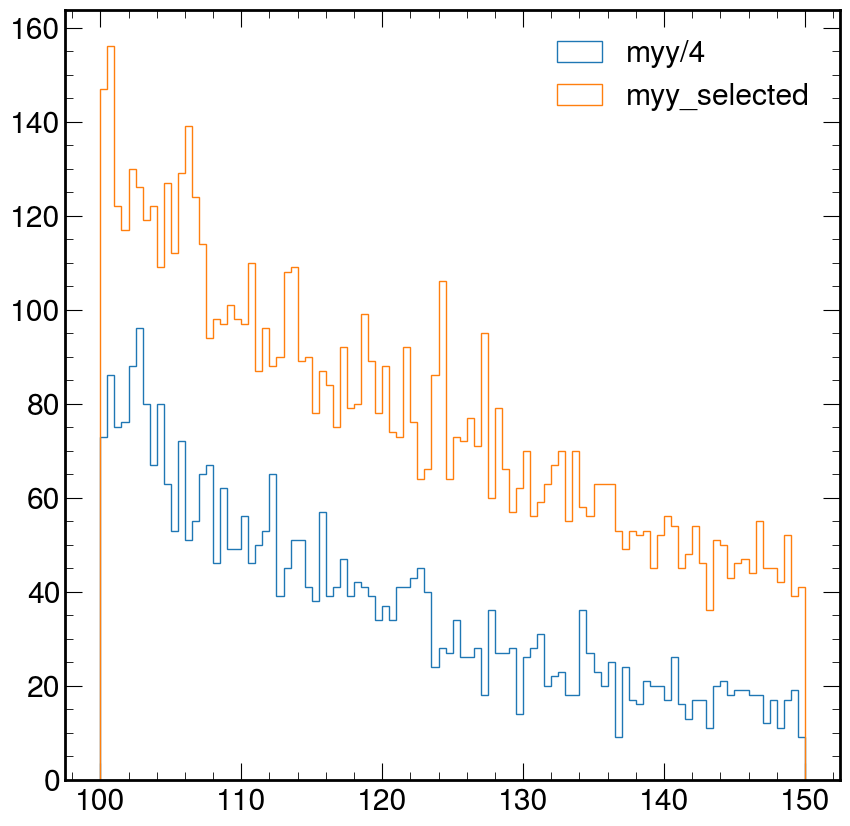

In [235]:
plt.hist(myy / 4, bins=100, range=(100, 150), histtype="step", label="myy/4")
plt.hist(
    myy_selected, bins=100, range=(100, 150), histtype="step", label="myy_selected"
)
plt.legend()

as you can easily see, the beak at the higgs boson mass started to be more clear when we applied cuts on the invariant mass

#### Lets have more formal plots, applying fits for signal, background and signal+background models, and get some statistical calculations.

In [236]:
xmin = 100  # GeV
xmax = 150  # GeV
step_size = 2  # GeV

bin_edges = np.arange(
    start=xmin,  # The interval includes this value
    stop=xmax + step_size,  # The interval doesn't include this value
    step=step_size,
)  # Spacing between values

bin_centres = np.arange(
    start=xmin + step_size / 2,  # The interval includes this value
    stop=xmax + step_size / 2,  # The interval doesn't include this value
    step=step_size,
)  # Spacing between values

In [237]:
def plot_data(myy_selected):
    # to have this function work, akward array needs to be converted to numpy array
    data_x, _ = np.histogram(myy_selected, bins=bin_edges)

    data_x_errors = np.sqrt(data_x)  # statistical error on the data

    plt.errorbar(
        x=bin_centres, y=data_x, yerr=data_x_errors, label="Data", fmt="ko"
    )  # 'k' means black and 'o' means circles

    # data fit
    polynomial_mod = PolynomialModel(4)  # 4th order polynomial
    gaussian_mod = GaussianModel()  # Gaussian
    # set initial guesses for the parameters of the polynomial model
    pars = polynomial_mod.guess(
        data_x,  # data to use to guess parameter values
        x=bin_centres,
        c0=np.max(myy_selected),
        c1=0,
        c2=0,
        c3=0,
        c4=0,
    )
    # set initial guesses for the parameters of the Gaussian model
    pars += gaussian_mod.guess(
        data_x,  # data to use to guess parameter values
        x=bin_centres,
        amplitude=200,
        center=125.0,
        sigma=2.4,
    )
    model = polynomial_mod + gaussian_mod  # combined model
    out = model.fit(
        data_x,  # data to be fit
        pars,  # guesses for the parameters
        x=bin_centres,
        weights=1 / data_x_errors,
    )  # fit the model to the data

    # background part of fit
    params_dict = out.params.valuesdict()  # get the parameters from the fit to data
    c0 = params_dict["c0"]  # c0 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    c1 = params_dict["c1"]  # c1 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    c2 = params_dict["c2"]  # c2 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    c3 = params_dict["c3"]  # c3 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    c4 = params_dict["c4"]  # c4 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
    # get the background only part of the fit to data
    background = (
        c0
        + c1 * bin_centres
        + c2 * bin_centres**2
        + c3 * bin_centres**3
        + c4 * bin_centres**4
    )

    signal_x = data_x - background  # data fit - background fit = signal fit
    print(signal_x)
    # plot the signal + background fit
    plt.plot(
        bin_centres,  # x
        out.best_fit,  # y
        "-r",  # single red line
        label="Sig+Bkg Fit ($m_H=125$ GeV)",
    )
    # plot the background only fit
    plt.plot(
        bin_centres,  # x
        background,  # y
        "--r",  # dashed red line
        label="Bkg (4th order polynomial)",
    )

    plt.ylabel("Events")  # write y-axis label for main axes
    # plt.ylim(100, 350)  # set the y axis limit for the main axes
    plt.xlabel(
        r"di-photon invariant mass $\mathrm{M_{\gamma\gamma}}$ [GeV]"
    )  # x-axis label

    # draw the legend
    plt.legend(frameon=False)  # no box around the legend

    print(f"chi^2 = {str(out.chisqr)}")
    print("gaussian centre = " + str(params_dict["center"]))
    print("gaussian sigma = " + str(params_dict["sigma"]))
    print("gaussian fwhm = " + str(params_dict["fwhm"]))

    return

[ -2.20417263  -7.8631549    5.987736    29.14057839 -22.67519204
  -4.79278227  19.39195805 -14.57946337 -13.2281815   16.86202605
  11.04473899 -11.38910562  23.78878664  23.74406748  -3.42025399
  -7.66381137  17.99111912   7.45961857  -3.40587457  -8.81556452
   1.95770184  -5.42156502   0.6485027    8.70713014  -3.76910021]
chi^2 = 9.961998627176436
gaussian centre = 125.99985424533237
gaussian sigma = 0.3936056603779894
gaussian fwhm = 0.9268704673598506


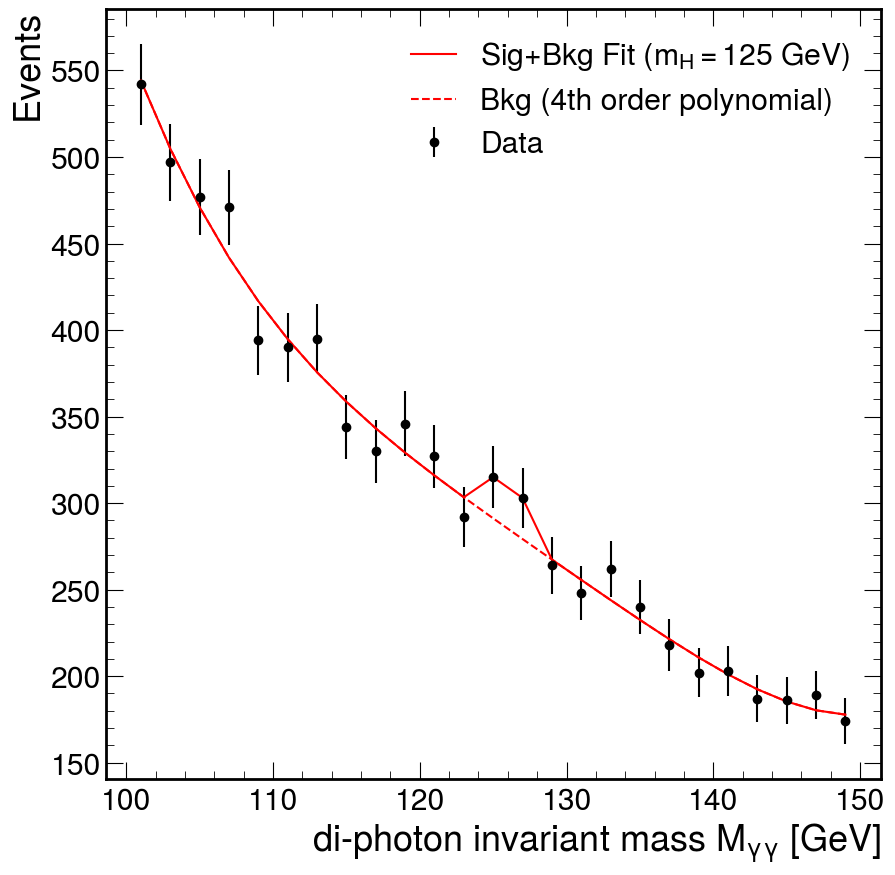

In [242]:
import mplhep as hep

hep.style.use("CMS")  # using CMS style from mplhep for plots
plot_data(myy_selected)

#### What can you do to explore this analysis?
* increase the quantity of data, i.e. add data_B, data_C and data_D? 
* Try different initial guesses for the parameters of the fit in 'Plotting'?
* Try different functions for the fit in 'Plotting'?
* Check how many events are being thrown away by each cut in 'Applying a cut'?
* Add more cuts from the Higgs discovery paper in 'Changing a cut' and 'Applying a cut'?
* Add some extra commands in 'Plotting' to make it look more similar to the Higgs discovery paper?
* Your idea!
* You can download more data by on your pc and add them in the input/GamGam/Data, or use the links directly without downloading.

##### you can download them by clicking on the link
https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_B.GamGam.root

https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_C.GamGam.root

https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/data_D.GamGam.root